Following NeRF literature I think that adding a positional encoding to the input of the network is a good idea. I will try to implement it and see if it improves the results.

In [50]:
# imports

import numpy as np 
import matplotlib.pyplot as plt 
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.__version__

'1.11.0'

## Try to fit one sinusoid

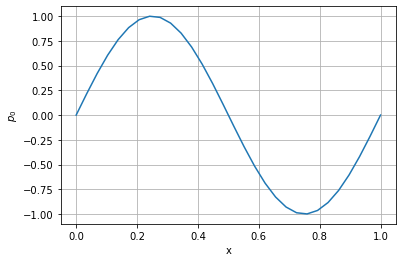

In [51]:
x= np.linspace(0, 1, 30)
p0 = np.sin(2*np.pi*x)

plt.plot(x, p0)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('$p_0$')
plt.show()

In [52]:
import torch
import numpy as np

class Sine(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.sin(x)


def block(i, o):
    fc = torch.nn.Linear(i, o)
    return torch.nn.Sequential(
        Sine(),
        torch.nn.Linear(i, o)
    )


def positional_encoding(x, L):
    B, D = x.shape
    embeddings = torch.pow(2., torch.arange(L, device=x.device)).unsqueeze(1).expand(-1, D) * (x[:, None]*2. - 1.) * np.pi
    return torch.cat((embeddings.sin(), embeddings.cos()), axis=-1).view(B, -1)


class MLP(torch.nn.Module):
    def __init__(self, inputs, outputs, layers, neurons):
        super().__init__()
        fc_in = torch.nn.Linear(inputs, neurons)
        fc_hidden = [
            block(neurons, neurons)
            for layer in range(layers-1)
        ]
        fc_out = block(neurons, outputs)
        self.mlp = torch.nn.Sequential(
            fc_in,
            *fc_hidden,
            fc_out
        )

    def forward(self, x):
        return self.mlp(x)


class MLP2(MLP):
    def __init__(self, inputs, outputs, layers, neurons, L):
        super().__init__(inputs, outputs, layers, neurons)
        self.mlp[0] = torch.nn.Linear(inputs*L*2, neurons)
        self.L = L

    def forward(self, x):
        x = positional_encoding(x, self.L)
        return self.mlp(x)

In [53]:
def train(model, N_STEPS = 300, log_each = 100):
	optimizer = torch.optim.Adam(model.parameters())
	criterion = torch.nn.MSELoss()
	xt = torch.tensor(x, dtype=torch.float32, device=device).view(-1, 1)
	y = torch.tensor(p0, dtype=torch.float32, device=device).view(-1, 1)
	for step in range(1, N_STEPS+1):
		y_hat = model(xt) 
		loss = criterion(y_hat, y)  
		# update
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		if step % log_each == 0:
			print(f'{step}/{N_STEPS} loss {loss.item():.8f}')
	return model

In [54]:
def eval(model):
	model.eval()
	xt = torch.tensor(x, dtype=torch.float32, device=device).view(-1, 1)
	with torch.no_grad():
		y_hat = model(xt)
		y_hat = y_hat.cpu().numpy()

	plt.plot(x, p0, label='p0')
	plt.plot(x, y_hat, '.k', label='y_hat')
	plt.grid(True)
	plt.xlabel('x')
	plt.ylabel('$p$')
	plt.legend()
	plt.show()

In [55]:
mlp = MLP(1, 1, 3, 32).to(device)
mlp = train(mlp)

100/300 loss 0.21177649
200/300 loss 0.20691974
300/300 loss 0.02088323


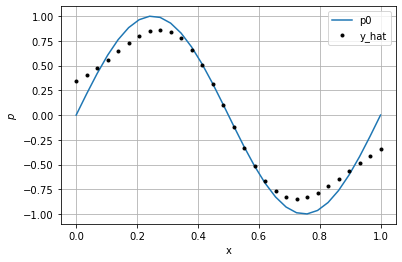

In [56]:
eval(mlp)

In [57]:
mlp2 = MLP2(1, 1, 3, 32, 5).to(device)
mlp2 = train(mlp2)

100/300 loss 0.00037705
200/300 loss 0.00009478
300/300 loss 0.00002683


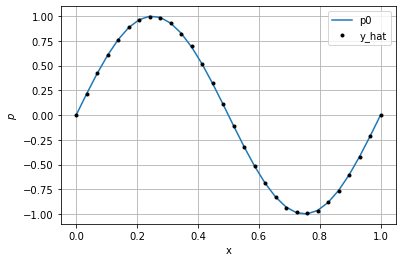

In [58]:
eval(mlp2)

Much faster convergence!

## Try to solve PDE

In [101]:
def get_samples(batch_size=100, n_inputs=2):
    return torch.rand((batch_size, n_inputs)) 

def get_samples_ini(batch_size=100):
    x = torch.rand(batch_size)
    p0 = torch.sin(2.*np.pi*x).unsqueeze(1)
    return torch.stack([  
        x,
        torch.zeros(batch_size)
    ], axis=-1), p0

def get_samples_boco(batch_size=100):
    t = torch.rand(batch_size)
    X0 = torch.stack([  
        torch.zeros(batch_size),
        t
    ], axis=-1)
    X1 = torch.stack([  
        torch.ones(batch_size),
        t
    ], axis=-1)
    return X0, X1

In [106]:
U = 1

def solve(model, BATCH_SIZE = 4000, N_STEPS = 2000, log_each = 100, Cp = 1., Cb = 1.):
	optimizer = torch.optim.Adam(model.parameters())
	# criterion = torch.nn.MSELoss()
	hist = []
	for step in range(1, N_STEPS+1):
		# optimize for PDE
		X = get_samples(BATCH_SIZE, 2) # N, (X, T)
		X.requires_grad_(True)
		y_hat = model(X.to(device)) # N, P 
		grads, = torch.autograd.grad(y_hat, X, grad_outputs=y_hat.data.new(y_hat.shape).fill_(1), create_graph=True, only_inputs=True)
		dpdx, dpdt = grads[:,0], grads[:,1]
		pde_loss = torch.nn.functional.mse_loss(dpdt, - U*dpdx)
		# optimize for initial condition
		X, p0 = get_samples_ini(BATCH_SIZE)
		y_hat = model(X.to(device)) # N, P0 
		ini_loss = torch.nn.functional.mse_loss(y_hat, p0.to(device))  
		# optimize for boundary conditions
		X0, X1 = get_samples_boco(BATCH_SIZE)
		y_0 = model(X0.to(device)) 
		y_1 = model(X1.to(device))
		bound_loss = torch.nn.functional.mse_loss(y_0, y_1)
		# update
		optimizer.zero_grad()
		loss = pde_loss*Cp + ini_loss + bound_loss*Cb
		loss.backward()
		optimizer.step()
		# log
		hist.append(loss.item())
		if step % log_each == 0:
			print(f'{step}/{N_STEPS} pde_loss {pde_loss.item():.5f} ini_loss {ini_loss.item():.5f} bound_loss {bound_loss.item():.10f}')
	return hist

In [107]:
def eval_model(model, N=10, t=0.):
    x = torch.linspace(0, 1, N)
    X = torch.stack([  # N0, (X, T = 0)
        x,
        torch.ones(N)*t
    ], axis=-1)
    model.eval()
    with torch.no_grad():
        p = model(X.to(device))
    return x.cpu().numpy(), p.cpu().numpy().ravel()

def plot_model(x, p, t):
    pe = np.sin(2.*np.pi*(x-U*t))
    plt.plot(x, pe, label="exact")
    plt.plot(x, p, '.k', label="solution")
    plt.legend()
    plt.grid(True)
    l2 = np.sqrt(np.sum((p-pe)**2))
    plt.title(f"t = {t:.3f} (L2 = {l2:.5f})")
    plt.show()

100/2000 pde_loss 0.00170 ini_loss 0.35465 bound_loss 0.0677013397
200/2000 pde_loss 0.01291 ini_loss 0.29670 bound_loss 0.0643079802
300/2000 pde_loss 0.01422 ini_loss 0.02570 bound_loss 0.0368374698
400/2000 pde_loss 0.00169 ini_loss 0.00087 bound_loss 0.0031300432
500/2000 pde_loss 0.00044 ini_loss 0.00072 bound_loss 0.0019281158
600/2000 pde_loss 0.00019 ini_loss 0.00035 bound_loss 0.0002943925
700/2000 pde_loss 0.00013 ini_loss 0.00018 bound_loss 0.0001298389
800/2000 pde_loss 0.00010 ini_loss 0.00012 bound_loss 0.0001053475
900/2000 pde_loss 0.00008 ini_loss 0.00008 bound_loss 0.0001135390
1000/2000 pde_loss 0.00007 ini_loss 0.00008 bound_loss 0.0001254788
1100/2000 pde_loss 0.00006 ini_loss 0.00005 bound_loss 0.0001077763
1200/2000 pde_loss 0.00005 ini_loss 0.00005 bound_loss 0.0000752783
1300/2000 pde_loss 0.00005 ini_loss 0.00005 bound_loss 0.0001518412
1400/2000 pde_loss 0.00005 ini_loss 0.00004 bound_loss 0.0000774493
1500/2000 pde_loss 0.00004 ini_loss 0.00004 bound_loss 0.

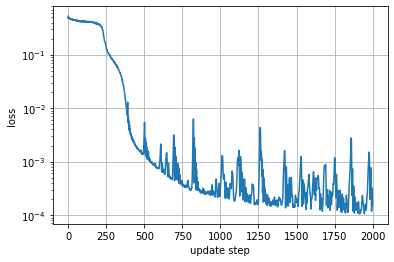

In [108]:
mlp = MLP(2, 1, 3, 100).to(device)
hist = solve(mlp)
plt.plot(hist)
plt.xlabel("update step")
plt.ylabel("loss")
plt.yscale("log")
plt.grid(True)
plt.show()

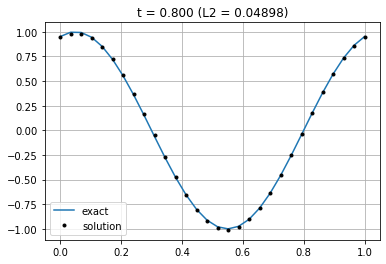

In [109]:
N, t = 30, 0.8
x, p = eval_model(mlp, N, t)
plot_model(x, p, t)

100/2000 pde_loss 63169.84766 ini_loss 0.00023 bound_loss 0.0000000034
200/2000 pde_loss 61726.19922 ini_loss 0.00015 bound_loss 0.0000000031
300/2000 pde_loss 61794.35156 ini_loss 0.00011 bound_loss 0.0000000030
400/2000 pde_loss 62125.63672 ini_loss 0.00007 bound_loss 0.0000000027
500/2000 pde_loss 58669.39453 ini_loss 0.00006 bound_loss 0.0000000028
600/2000 pde_loss 59926.22656 ini_loss 0.00007 bound_loss 0.0000000030
700/2000 pde_loss 57455.31250 ini_loss 0.00004 bound_loss 0.0000000027
800/2000 pde_loss 59702.30469 ini_loss 0.00004 bound_loss 0.0000000026
900/2000 pde_loss 59498.64453 ini_loss 0.00003 bound_loss 0.0000000026
1000/2000 pde_loss 55533.78516 ini_loss 0.00002 bound_loss 0.0000000026
1100/2000 pde_loss 56247.09766 ini_loss 0.00003 bound_loss 0.0000000025
1200/2000 pde_loss 56953.49219 ini_loss 0.00004 bound_loss 0.0000000026
1300/2000 pde_loss 56501.10156 ini_loss 0.00027 bound_loss 0.0000000025
1400/2000 pde_loss 54003.10156 ini_loss 0.00002 bound_loss 0.0000000024
1

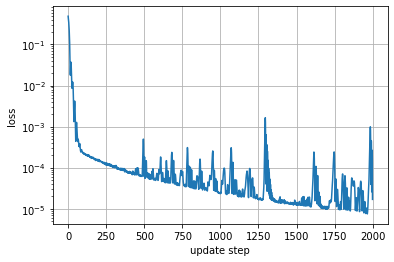

In [116]:
mlp2 = MLP2(2, 1, 3, 100, 10).to(device)
hist = solve(mlp2, Cb=0., Cp=0.)
plt.plot(hist)
plt.xlabel("update step")
plt.ylabel("loss")
plt.yscale("log")
plt.grid(True)
plt.show()

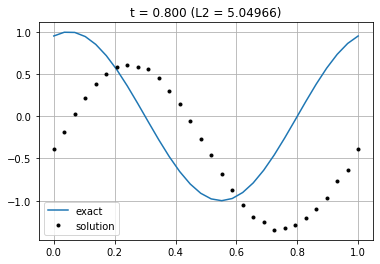

In [117]:
N, t = 30, 0.8
x, p = eval_model(mlp2, N, t)
plot_model(x, p, t)

Not working very well...